<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import warnings
from scipy.stats import ttest_rel
import statsmodels.stats.multitest as smm
from statsmodels.stats.power import TTestPower
import matplotlib.patches as patches

# Function for stars
def p_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

warnings.filterwarnings("ignore")

Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):

0.2 mg/kg  | t = -0.586 | p = 0.5763 | corrected p = 0.5763 | significant: ns
0.3 mg/kg  | t =  1.420 | p = 0.1986 | corrected p = 0.3972 | significant: ns
0.4 mg/kg  | t =  8.333 | p = 7.021e-05 | corrected p = 0.0002106 | significant: ***
0.6 mg/kg  | t =  9.327 | p = 3.381e-05 | corrected p = 0.0001352 | significant: ***


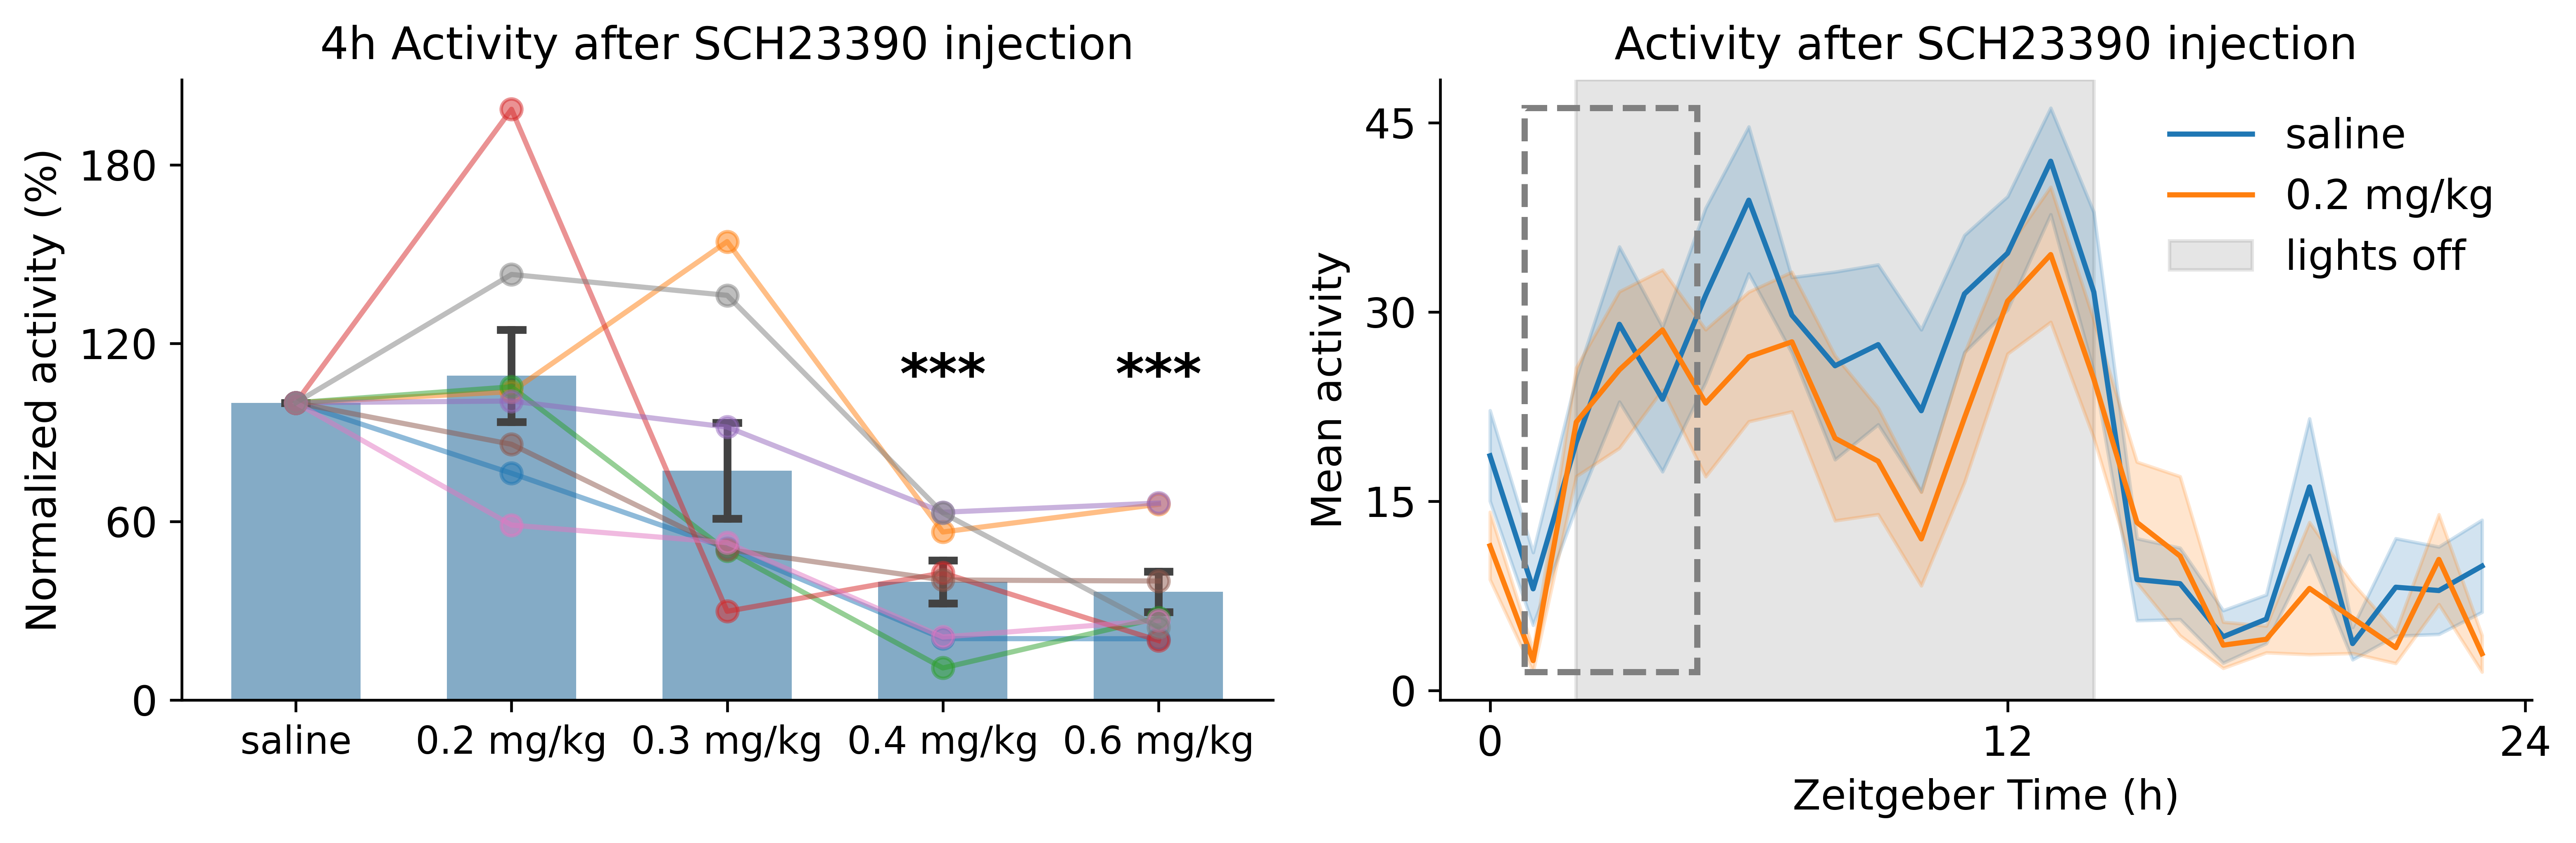

In [2]:
# @title Figure S2A-B
# Load and preprocess data
df1 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2_a.csv")

conditions = ['0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_means = df1[df1['day_label'] == 'saline'].set_index('id')['mean']
saline_vals = df1[df1['day_label'] == 'saline'].set_index('id')['mean_normalized']

# Run paired t-tests
pvals = []
comparisons = []

for condition in conditions:
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Holm-Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='holm')

print("Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df1, 
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df1['id'].unique():
    individual_data = df1[df1['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after SCH23390 injection', fontsize=13)
ax1.set_ylabel('Normalized activity (%)', fontsize=12)
ax1.set_xlabel('', fontsize=12)
custom_labels = ['saline', '0.2 mg/kg', '0.3 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=12)
ax1.legend([], frameon=False)

y_offset = df1['mean_normalized'].max() * .5
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

df2 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2_b.csv")

# Figure 2: Lineplot
ax2 = axes[1]
sns.lineplot(
    data=df2, 
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=12)
ax2.set_ylabel("Mean activity", fontsize=12)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=12)
ax2.tick_params(axis='y',labelsize = 12)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after SCH23390 injection', fontsize=13)

# Compute mean and SEM for each group
summary = df2.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# Adjust layout
plt.tight_layout()
plt.show()

Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):

0.1 mg/kg  | t =  0.878 | p = 0.4092 | corrected p = 0.4092 | significant: ns
0.2 mg/kg  | t =  7.445 | p = 0.0001439 | corrected p = 0.0005754 | significant: ***
0.4 mg/kg  | t =  4.788 | p = 0.001993 | corrected p = 0.005187 | significant: **
0.6 mg/kg  | t =  4.912 | p = 0.001729 | corrected p = 0.005187 | significant: **


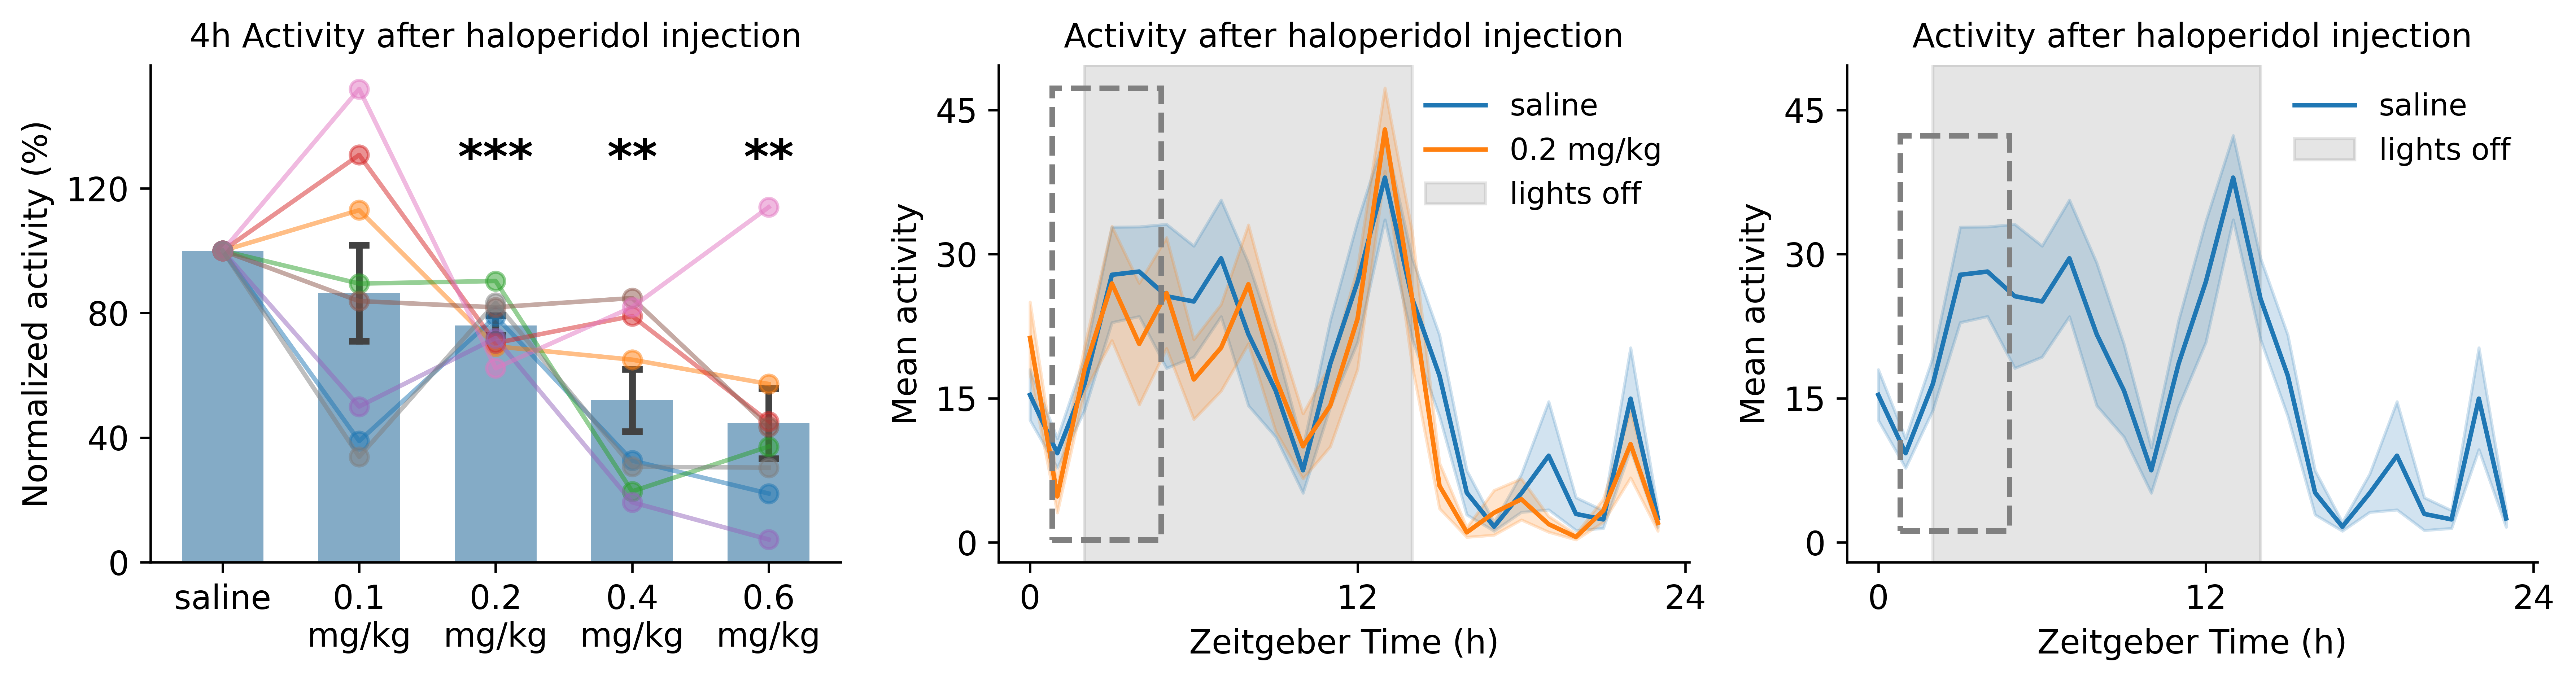

In [4]:
# @title Figure S2C-D
# Load and preprocess data
df1 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2_c.csv")
# Run paired t-tests
pvals = []
comparisons = []
conditions = ['0.1 mg/kg', '0.2 mg/kg', '0.4 mg/kg', '0.6 mg/kg']
saline_means = df1[df1['day_label'] == 'saline'].set_index('id')['mean']
saline_vals = df1[df1['day_label'] == 'saline'].set_index('id')['mean_normalized']

for condition in conditions:
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    pvals.append(p)
    comparisons.append((condition, p))

# Holm-Bonferroni correction
reject, pvals_corrected, _, _ = smm.multipletests(pvals, method='holm')

print("Statistical comparison (paired t-tests vs saline with Holm-Bonferroni correction):\n")
for (condition, raw_p), corrected_p, rej in zip(comparisons, pvals_corrected, reject):
    drug_vals = df1[df1['day_label'] == condition].set_index('id')['mean_normalized']
    common_ids = saline_vals.index.intersection(drug_vals.index)
    tstat, p = ttest_rel(saline_vals.loc[common_ids], drug_vals.loc[common_ids])
    star = p_to_star(corrected_p)
    print(f"{condition:<10} | t = {tstat:>6.3f} | p = {raw_p:.4g} | corrected p = {corrected_p:.4g} | significant: {star or 'ns'}")

fig, axes = plt.subplots(1, 3, figsize=(12, 3.25), dpi=600)

# Figure 1: Barplot with line plots
ax1 = axes[0]
sns.barplot(
    data=df1,
    x='day_label',
    y='mean_normalized',
    errorbar='se',
    alpha=0.6,
    capsize=0.1,
    width=0.6,
    ax=ax1
)

for individual_id in df1['id'].unique():
    individual_data = df1[df1['id'] == individual_id]
    ax1.plot(
        individual_data['day_label'],
        individual_data['mean_normalized'],
        marker='o',
        linestyle='-',
        label=individual_id,
        zorder=4,
        alpha=0.5
    )

ax1.set_title('4h Activity after haloperidol injection', fontsize=11)
ax1.set_ylabel('Normalized activity (%)', fontsize=11)
ax1.set_xlabel('', fontsize=11)
custom_labels = ['saline', '0.1\nmg/kg', '0.2\nmg/kg', '0.4\nmg/kg', '0.6\nmg/kg']
ax1.set_xticks(range(len(custom_labels)))
ax1.set_xticklabels(custom_labels, fontsize=11)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax1.tick_params(axis='y', labelsize=11)
ax1.legend([], frameon=False)

y_offset = df1['mean_normalized'].max() * .8
for i, (condition, p_corr) in enumerate(zip(conditions, pvals_corrected), start=1):  # start=1 to match bar positions
    star = p_to_star(p_corr)
    if star:
        ax1.text(
            i, y_offset, star,
            ha='center',
            va='bottom',
            fontsize=16,
            color='black',
            fontweight='bold'
        )

sns.despine(ax=ax1, top=True, right=True)

df2 = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2_d.csv")

# ---- circadian panel (saline vs 0.2 mg/kg only) ----
subset_labels = ['saline', '0.2 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]

ax2 = axes[1]
sns.lineplot(
    data=df_subset,  
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax2
)

x_ticks = [0, 12, 24]
x_tick_labels = ['0', '12', '24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=11)
ax2.set_ylabel("Mean activity", fontsize=11)
ax2.set_xlabel('Zeitgeber Time (h)', fontsize=11)
ax2.tick_params(axis='y',labelsize = 11)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax2.legend(loc='upper right', frameon=False, fontsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Activity after haloperidol injection', fontsize=11)

# Compute mean and SEM for each group
summary = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()

# Compute global ymin and ymax across the whole time range
summary['lower'] = summary['mean'] - summary['sem']
summary['upper'] = summary['mean'] + summary['sem']
ymin = summary['lower'].min()
ymax = summary['upper'].max()

# Create and add the dashed rectangle from ZT1 to ZT5
box = patches.Rectangle(
    (0.8, ymin),           # Lower-left corner: ZT1
    4,                   # Width from ZT1 to ZT5 (ZT5 − ZT1 = 4)
    ymax - ymin,         # Height from global lower to upper bound
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax2.add_patch(box)

# ---- circadian panel (saline vs 0.4 mg/kg only) ----
ax3 = axes[2]

# Subset data to only saline and 0.4 mg/kg
subset_labels = ['saline', '0.4 mg/kg']
df_subset = df2[df2['day_label'].isin(subset_labels)]
custom_palette = {
    'saline': 'tab:blue',     # default first color
    '0.4 mg/kg': 'tab:red'  # default third color
}

sns.lineplot(
    data=df_subset,
    x="zthour",
    y="mean",
    hue="day_label",
    errorbar="se",
    ax=ax3,
    palette=custom_palette
)

# Axis formatting (match ax2 for consistency)
x_ticks = [0, 12, 24]
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(['0', '12', '24'], fontsize=11)
ax3.set_ylabel("Mean activity", fontsize=11)
ax3.set_xlabel("Zeitgeber Time (h)", fontsize=11)
ax3.tick_params(axis='y', labelsize=11)
ax3.yaxis.set_major_locator(MaxNLocator(4))
ax3.axvspan(2, 14, color='gray', alpha=.2, zorder=0, label='lights off')
ax3.legend(loc='upper right', frameon=False, fontsize=10)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Activity after haloperidol injection', fontsize=11)

# Add dashed rectangle highlighting ZT1–ZT5 window
summary_sub = df_subset.groupby(['day_label', 'zthour'])['mean'].agg(['mean', 'sem']).reset_index()
summary_sub['lower'] = summary_sub['mean'] - summary_sub['sem']
summary_sub['upper'] = summary_sub['mean'] + summary_sub['sem']
ymin = summary_sub['lower'].min()
ymax = summary_sub['upper'].max()

box = patches.Rectangle(
    (0.8, ymin),  # Lower-left corner at ~ZT1
    4,            # Width (ZT5 − ZT1 = 4)
    ymax - ymin,  # Height
    linewidth=1.8,
    edgecolor='gray',
    facecolor='none',
    linestyle='--',
    zorder=5
)
ax3.add_patch(box)
ymin = min(ax2.get_ylim()[0], ax3.get_ylim()[0])
ymax = max(ax2.get_ylim()[1], ax3.get_ylim()[1])
ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

# Adjust layout
plt.tight_layout()
plt.show()